<a href="https://colab.research.google.com/github/Andrey-Epifanov-k721/conv_networks/blob/master/Autoencoder_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

import torchvision.transforms as transforms
from PIL import Image

import torch
import torch.nn as nn

%matplotlib inline

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [3]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [4]:
from sklearn.model_selection import train_test_split

# Разбиваем данные на обучающую и валидационную выборки в соотношении 80/20
train_data, val_data, train_attrs, val_attrs = train_test_split(data, attrs, test_size=0.2, random_state=42)


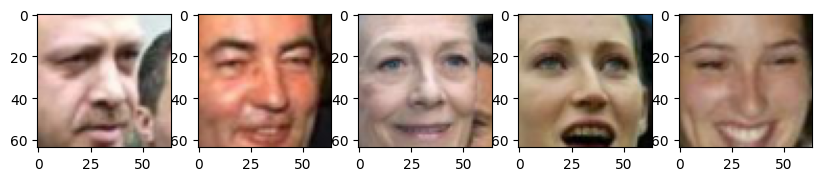

(64, 64, 3)
(10514, 73)


In [5]:
# выведем картинки из тренировочного набора данных
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(10, 5))
for i in range(5):
    axs[i].imshow(train_data[i])
plt.show()

print(train_data[0].shape)
print(train_attrs.shape)


In [6]:
# создаем трансформации
transform = transforms.Compose([
    transforms.ToTensor(),  # приводим к тензору
    transforms.Normalize((0.5,), (0.5,))  # нормализуем значения пикселей
])

# применяем трансформации к train_data и val_data
def transform_dataset(dataset):
    transformed_dataset = []
    for img in dataset:
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img.cpu())
        img = transform(img)
        transformed_dataset.append(img)
    return transformed_dataset

train_data = transform_dataset(train_data)
val_data = transform_dataset(val_data)

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [14]:
# размер латентного вектора
dim_code = 16

In [15]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
# # работает
# from copy import deepcopy

# class Autoencoder(nn.Module):
#     def __init__(self, input_size, dim_code):
#         super(Autoencoder, self).__init__()

#         # Encoder
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
#         self.fc1 = nn.Linear(32 * 16 * 16, dim_code)

#         # Decoder
#         self.fc2 = nn.Linear(dim_code, 32 * 16 * 16)
#         self.conv3 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
#         self.conv4 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1)

#     def forward(self, x):
#         # Encoder
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = x.view(-1, 32 * 16 * 16)
#         code = F.relu(self.fc1(x))

#         # Decoder
#         x = F.relu(self.fc2(code))
#         x = x.view(-1, 32, 16, 16)
#         x = F.relu(self.conv3(x))
#         x = torch.tanh(self.conv4(x))
#         return x, code

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, dim_code):
        super(Autoencoder, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, dim_code)

        # Decoder
        self.fc2 = nn.Linear(dim_code, 32 * 16 * 16)
        self.conv3 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv4 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1)

    def encoder(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 32 * 16 * 16)
        code = F.relu(self.fc1(x))
        return code

    def decoder(self, code):
        # Decoder
        x = F.relu(self.fc2(code))
        x = x.view(-1, 32, 16, 16)
        x = F.relu(self.conv3(x))
        x = torch.tanh(self.conv4(x))
        return x

    def forward(self, x):
        code = self.encoder(x)
        x = self.decoder(code)
        return x, code

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
def train(model, criterion, optimizer, train_loader, val_loader, num_epochs, n_pictures):
    # переводим модель в режим обучения
    model.train()
    
    for epoch in range(num_epochs):
        # итерируемся по батчам в train_loader
        for batch in train_loader:
            # извлекаем данные из текущего батча
            images = batch
            
            # переносим данные на GPU, если он есть, и изменяем тип тензора на torch.cuda.FloatTensor
            if torch.cuda.is_available():
                images = images.cuda()#.type(torch.cuda.FloatTensor)
            
            # обнуляем градиенты
            optimizer.zero_grad()
            
            # применяем автоэнкодер
            reconstructed, latent_code = model(images)
            # reconstructed = reconstructed.double()

            # вычисляем функцию потерь
            loss = criterion(reconstructed, images)
            
            # обновляем параметры модели
            loss.backward()
            optimizer.step()

        # output reconstruction image
        visualize(model, train_loader, val_loader, device, n_pictures)
        
        # выводим информацию о процессе обучения
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
import torchvision.utils as vutils
def visualize(model, train_loader, val_loader, device, num_images):
    model.eval()
    data_iter = iter(train_loader)
    images = next(data_iter)
    images = images[:num_images].to(device)

    val_iter = iter(val_loader)
    val_images = next(val_iter)
    val_images = val_images[:num_images].to(device)


    with torch.no_grad():
        recons = model(images)
        val_recons = model(val_images)


    images_grid = vutils.make_grid(images.cpu(), nrow=8, normalize=True, padding=2)
    val_images_grid = vutils.make_grid(val_images.cpu(), nrow=8, normalize=True, padding=2)

    if isinstance(recons, tuple):
        recons_grid = vutils.make_grid(recons[0].cpu(), nrow=num_images, normalize=True)
    else:
        try:
            recons_grid = vutils.make_grid(recons.cpu(), nrow=num_images, normalize=True)
        except:
            recons_grid = vutils.make_grid(torch.stack(recons).cpu(), nrow=num_images, normalize=True)

    if isinstance(val_recons, tuple):
        val_recons_grid = vutils.make_grid(val_recons[0].cpu(), nrow=num_images, normalize=True)
    else:
        try:
            val_recons_grid = vutils.make_grid(val_recons.cpu(), nrow=num_images, normalize=True)
        except:
            val_recons_grid = vutils.make_grid(torch.stack(val_recons).cpu(), nrow=num_images, normalize=True)

    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    axes[0, 0].imshow(images_grid.permute(1, 2, 0))
    axes[0, 0].set_title('Original Images - train')
    axes[1, 0].imshow(recons_grid.permute(1, 2, 0))
    axes[1, 0].set_title('Reconstructed - train')

    axes[0, 1].imshow(val_images_grid.permute(1, 2, 0))
    axes[0, 1].set_title('Original Images - val')
    axes[1, 1].imshow(val_recons_grid.permute(1, 2, 0))
    axes[1, 1].set_title('Reconstructed - val')

    # for ax in axes.flatten():
    #     ax.axis('off')

    # Также можно получить латентный вектор для всего датасета, проходя по нему в цикле:
    latent_vectors = []
    for img in train_loader:
        with torch.no_grad():
            img = img.to(device)
            latent_vector = model.encoder(img)
            latent_vectors.append(latent_vector.cpu().numpy())
    latent_vectors = np.concatenate(latent_vectors)
    plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1])


    plt.show() 


In [ ]:
criterion = nn.MSELoss()

model = Autoencoder(input_size=(3, 64, 64), dim_code=32).to(device, dtype=torch.double)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


torch.float64


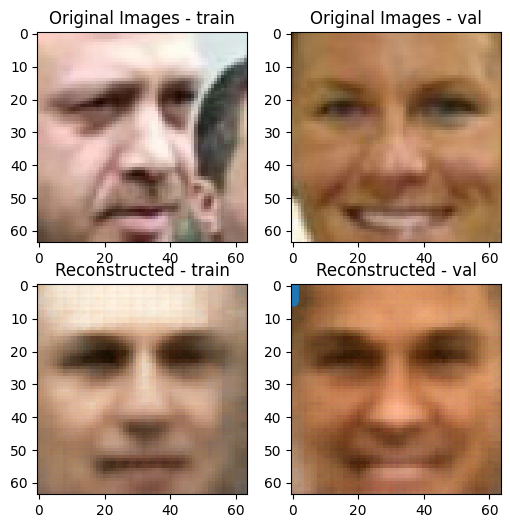

Epoch [1/3], Loss: 0.0363


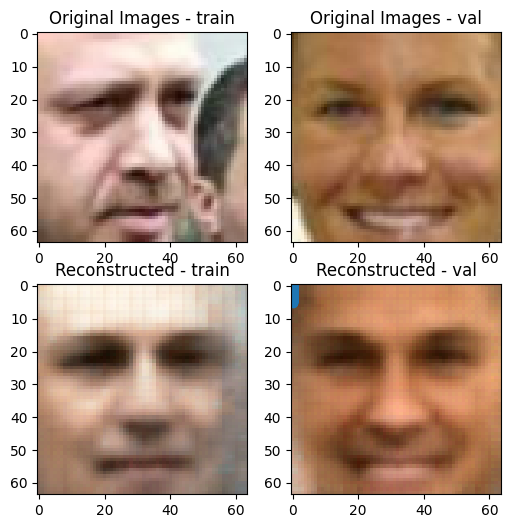

Epoch [2/3], Loss: 0.0337


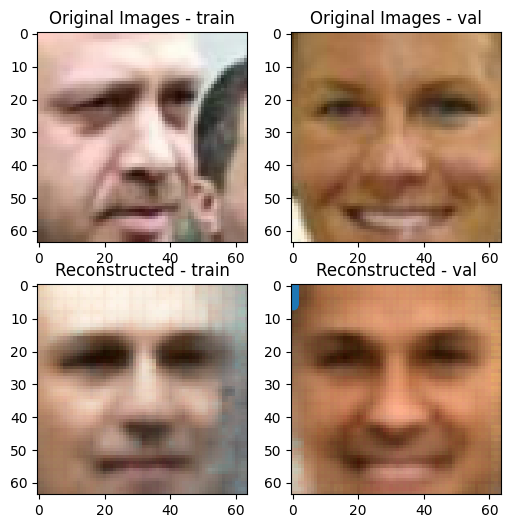

Epoch [3/3], Loss: 0.0333


In [ ]:
n_pictures = 3
batch_size = 32

num_epochs = 3

print(train_data[0].dtype)

train(model, criterion, optimizer, train_data, val_data, num_epochs, n_pictures)


Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

**Ниже представлено декодирование изображения только по сгенерированному вектору**

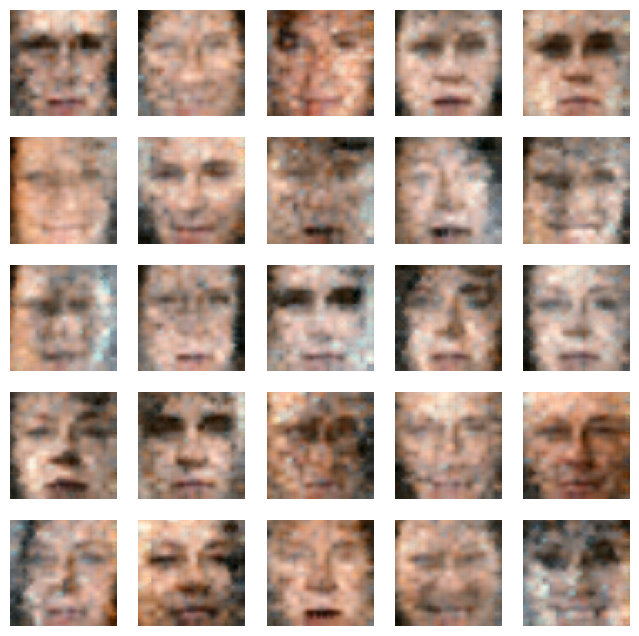

In [ ]:
# работает, но немного неправильно
latent_space_dim = 32

# сгенерируем 32 рандомных векторов размера latent_space
z = np.random.uniform(low=-0.5, high=3, size=(8192, latent_space_dim))

# сконвертируем numpy массив в тензор и передадим его в декодер
z = torch.from_numpy(z).to(device)

# изменяем размерность тензора z
z = z.view(-1, latent_space_dim)

decoder_tensor = model.decoder(z).to(device)

# выведем полученные картинки
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = decoder_tensor[i].detach().cpu().permute(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())  # нормализуем значения пикселей
    ax.imshow(img)
    ax.axis('off')
plt.show()


<class 'torch.Tensor'>


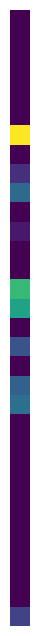

In [ ]:
# Получим от энкодера вектор латентного пространства
# Генерируем случайный тензор размером (batch_size, 3, height, width)
batch_size = 32
# x = torch.randn(batch_size, 3, 16, 16).double().to(device)
x = torch.randn(32, 3, 3, batch_size).double().to(device)

# Получаем векторы латентного пространства
with torch.no_grad():
    codes = model.encoder(x)

print(type(codes))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
axes.imshow(codes[0].detach().cpu().numpy().reshape(-1, 1))
axes.axis('off')
plt.show()



**Ниже показан результат декодирования по сумме сгенерированного вектора + вектора латентного пространства**

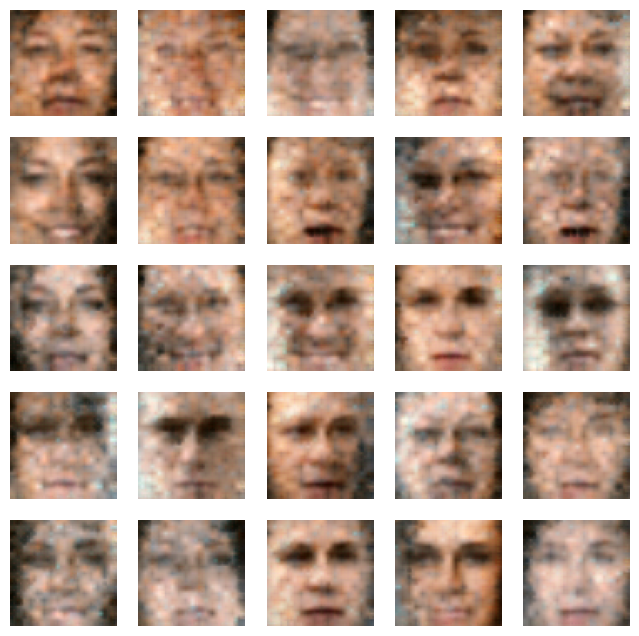

In [ ]:
latent_space_dim = 32

# сгенерируем 32 рандомных векторов размера latent_space
z = np.random.uniform(low=-0.5, high=3, size=(8192, latent_space_dim))

# сконвертируем numpy массив в тензор и передадим его в декодер
z = torch.from_numpy(z).to(device)

# сложим вгенерированный случайный вектор и вектор codes из латентного пространства автоэнкодера
z = torch.add(codes, z)

# изменяем размерность тензора z
z = z.view(-1, latent_space_dim)

decoder_tensor = model.decoder(z).to(device)


# # выведем полученные картинки
# fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8))
# for i, ax in enumerate(axes.flat):
#     ax.imshow(decoder_tensor[i].detach().cpu().permute(1, 2, 0))
#     ax.axis('off')
# plt.show()

# выведем полученные картинки
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = decoder_tensor[i].detach().cpu().permute(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())  # нормализуем значения пикселей
    ax.imshow(img)
    ax.axis('off')
plt.show()

<ipython-input-158-585032681369>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = z = torch.tensor(z).to(device)


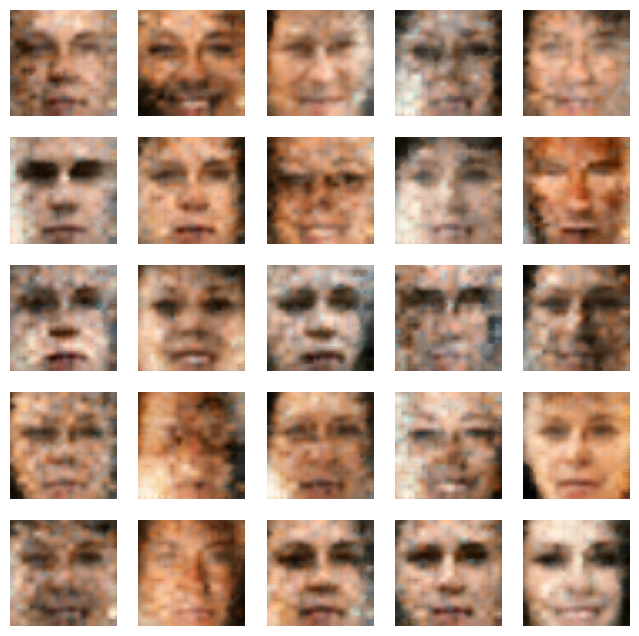

In [ ]:
latent_space_dim = 32

# сгенерируем 32 рандомных векторов размера latent_space
mean = 1.5
std = 1.3
z = torch.normal(mean=mean, std=std, size=(8192, latent_space_dim))

# сконвертируем numpy массив в тензор и передадим его в декодер
z = z = torch.tensor(z).to(device)

# сложим вгенерированный случайный вектор и вектор codes из латентного пространства автоэнкодера
z = torch.add(codes, z)

# изменяем размерность тензора z
z = z.view(-1, latent_space_dim)

decoder_tensor = model.decoder(z).to(device)


# # выведем полученные картинки
# fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8))
# for i, ax in enumerate(axes.flat):
#     ax.imshow(decoder_tensor[i].detach().cpu().permute(1, 2, 0))
#     ax.axis('off')
# plt.show()

# выведем полученные картинки
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = decoder_tensor[i].detach().cpu().permute(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())  # нормализуем значения пикселей
    ax.imshow(img)
    ax.axis('off')
plt.show()

## 1.5 Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
<ваш код здесь>

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [19]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 78935328.71it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 63554928.55it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26860334.15it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 25571179.55it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [9]:
import torch.nn.functional as F

def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    # print(f"mu shape: {mu.shape}")
    # print(f"logsigma shape: {logsigma.shape}")

    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')
    return loss

def loss_vae(x, mu, logsigma, reconstruction):
    """
    Соединяем две компоненты лосса: KL-дивергенцию и log-likelihood
    """
    # print(f"mu shape: {mu.shape}")
    # print(f"logsigma shape: {logsigma.shape}")

    kl_loss = KL_divergence(mu, logsigma)
    ll_loss = log_likelihood(x, reconstruction)
    loss = kl_loss + ll_loss
    return loss


И обучим модель:

In [11]:
# работает, вставляю batch_size
def train_vae(model, dataloader, optimizer, criterion, device, num_epochs):
    model.train()
    
    for epoch in range(num_epochs):
        train_loss = 0

        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)

            # сбросим градиенты перед forward pass
            optimizer.zero_grad()
            # print('optimizer zero_grad дошел')

            mu, logsigma, reconstruction = model(x)

            # посчитаем функцию потерь
            loss = criterion(x, mu, logsigma, reconstruction)
            # print('loss дошел')
            
            # backward pass
            loss.backward()
            # print('loss backward дошел')

            # update weights
            optimizer.step()
            # print('optimizer step дошел')

            train_loss += loss.item()
            # print('train_loss дошел')

        print(f'Epoch {epoch + 1}, loss: {train_loss / len(dataloader.dataset):.4f}')

    return

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_shape=(1, 28, 28), latent_dim=16):
        super(VAE, self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
        )

        for param in self.encoder.parameters():
            param.requires_grad = False

        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logsigma = nn.Linear(256, latent_dim)

        self.fc3 = nn.Linear(latent_dim, 256)
        self.fc4 = nn.Linear(256, 64 * 7 * 7)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_shape[0], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

        # for param in autoencoder.decoder.parameters():
        #     param.requires_grad = True

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logsigma = self.fc_logsigma(x)
        return mu, logsigma

    def reparameterize(self, mu, logsigma):
        std = torch.exp(0.5 * logsigma)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = z.view(-1, 64, 7, 7)  # изменяем размерность
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.reparameterize(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# autoencoder = VAE(input_shape=(16,16,1), latent_dim=32).to(device)
autoencoder = VAE(latent_dim=28).to(device)


optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, autoencoder.parameters()), lr=0.001)



In [ ]:
# Получаем первый батч из train_loader
data, labels = next(iter(train_loader))

# Проверяем размерность батча
print(data.shape)
print(labels.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [ ]:
epochs = 10

train_vae(autoencoder, train_loader, optimizer, loss_vae, device, epochs)



Epoch 1, loss: 121.6540
Epoch 2, loss: 120.9493
Epoch 3, loss: 120.3020
Epoch 4, loss: 119.7627
Epoch 5, loss: 119.2142
Epoch 6, loss: 118.6746
Epoch 7, loss: 118.1695
Epoch 8, loss: 117.8471
Epoch 9, loss: 117.4417
Epoch 10, loss: 117.0952


Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [23]:
def visualize_vae(model, dataloader, device, num_images):
    model.eval()
    with torch.no_grad():
        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)
            _, _, output = model(x)
            x = x[:num_images].permute(0, 2, 3, 1).cpu().numpy() # оригинальные изображения
            output = output[:num_images].permute(0, 2, 3, 1).cpu().numpy() # переставляем порядок осей и преобразуем в numpy
            fig, axs = plt.subplots(2, num_images, figsize=(15, 2)) # создаем сетку изображений
            for j in range(num_images):
                axs[0, j].imshow(x[j], cmap='gray') # отображаем оригинальные изображения в оттенках серого
                axs[0, j].axis('off')
                axs[1, j].imshow(output[j], cmap='gray') # отображаем восстановленные изображения в оттенках серого
                axs[1, j].axis('off')
            axs[0, 0].set_title('Original Images', loc='center') # подписываем первый ряд изображений
            axs[1, 0].set_title('Reconstructed Images', loc='center') # подписываем второй ряд изображений
            plt.show()
            if i == 0:
                break


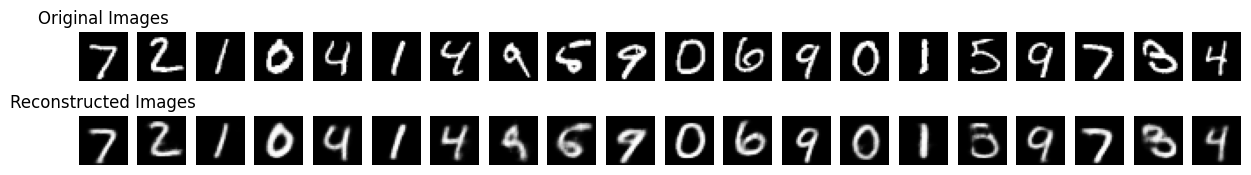

In [ ]:
visualize_vae(autoencoder, test_loader, device, 20)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

<ipython-input-203-f9c9699c590f>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = z = torch.tensor(z).to(device)


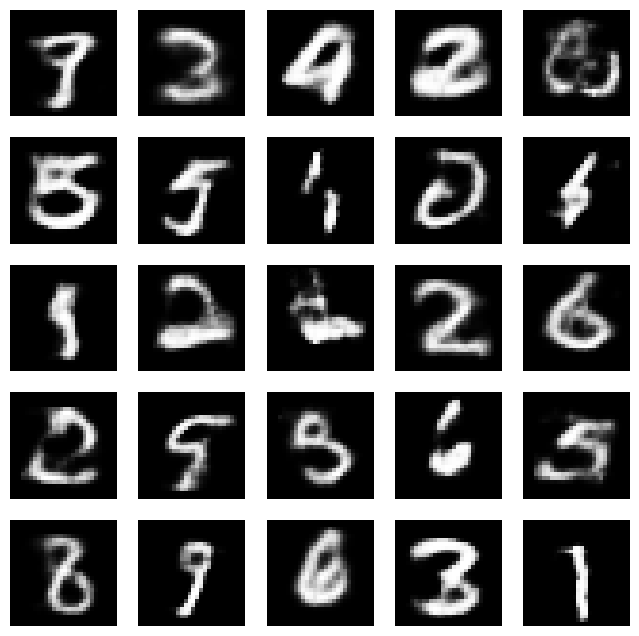

In [ ]:
latent_space_dim = 28

# сгенерируем 32 рандомных векторов размера latent_space
mean =0
std = 1
z = torch.normal(mean=mean, std=std, size=(256, latent_space_dim))

# сконвертируем numpy массив в тензор и передадим его в декодер
z = z = torch.tensor(z).to(device)

# изменяем размерность тензора z
z = z.view(-1, latent_space_dim)

decoder_tensor = autoencoder.decode(z).to(device)


# выведем полученные картинки
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = decoder_tensor[i].detach().cpu().permute(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())  # нормализуем значения пикселей
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

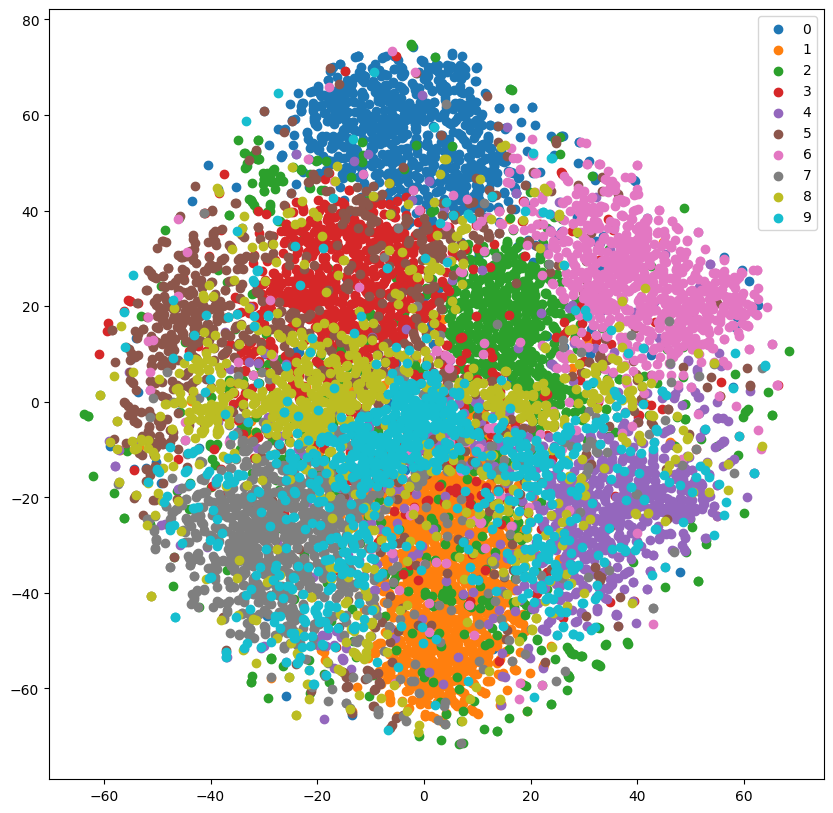

In [ ]:
from sklearn.manifold import TSNE

# Получаем латентные представления для тестового датасета
test_latent = []
test_labels = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        mu, logvar, _ = autoencoder(x)
        z = autoencoder.reparameterize(mu, logvar)
        test_latent.append(z.cpu().numpy())
        test_labels.append(y.numpy())

test_latent = np.concatenate(test_latent, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Сжимаем латентные представления до двумерной размерности
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
test_latent_2d = tsne.fit_transform(test_latent)

# Визуализируем точки в двумерном пространстве, покрасив их в разные цвета
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.scatter(test_latent_2d[test_labels == i, 0], test_latent_2d[test_labels == i, 1], label=str(i))
plt.legend()
plt.show()


Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [32]:
class CVAE(nn.Module):
    def __init__(self, input_shape=(1, 28, 28), latent_dim=10, num_classes=10):
        super(CVAE, self).__init__()
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=10, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=10, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten()                                            # (10x10x64 = 6400) на самом деле [1, 6400]
        )

        for param in self.encoder.parameters():
            param.requires_grad = False

        self.fc_mu = nn.Linear(6410, latent_dim)
        self.fc_logsigma = nn.Linear(6410, latent_dim)

        self.fc3 = nn.Linear(latent_dim + 10, 256)
        self.fc4 = nn.Linear(256, 64 * 7 * 7)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_shape[0], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x, y):
        # print(x.size())  # Вывод размерности x                  # [1, 1, 28, 28]
        # print(y.size())  # Вывод размерности y                  # [1]

        x = self.encoder(x)                                     # [1, 6400]                                       
        # print(x.size())  # Вывод размерности y                  

        y = F.one_hot(y, num_classes=self.num_classes).float()  # [1, 10]
        # print(y.size())  # Вывод размерности y                  

        x = torch.cat((x, y), dim=1)                            # [1, 6410]
        # print(x.size())  # Вывод размерности x итоговый

        mu = self.fc_mu(x)
        logsigma = self.fc_logsigma(x)
        return mu, logsigma


    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    # В данном коде происходит декодирование латентного вектора z и метки класса y в восстановленное изображение.
    def decode(self, z, y):
        y = F.one_hot(y, num_classes=self.num_classes).float()  # One-hot encoding
        z = torch.cat((z, y), dim=1)
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = z.view(-1, 64, 7, 7)
        reconstruction = self.decoder(z)
        return reconstruction


    def forward(self, x, y):
        mu, logsigma = self.encode(x, y)
        z = self.gaussian_sampler(mu, logsigma)
        # print('отлажено до reconstruction')
        reconstruction = self.decode(z, y)
        return mu, logsigma, reconstruction


In [12]:
def train_cvae(model, dataloader, optimizer, criterion, device, num_epochs):
    model.train()

    for epoch in range(num_epochs):
        train_loss = 0

        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            for image, label in zip(images, labels):
                image = image.unsqueeze(0)  # добавляем размерность пакета 1
                label = label.unsqueeze(0)  # добавляем размерность пакета 1

                optimizer.zero_grad()
                mu, logsigma, reconstruction = model(image, label)

                loss = criterion(image, mu, logsigma, reconstruction)

                loss.backward()
                optimizer.step()

                train_loss += loss.item()

        print(f'Epoch {epoch + 1}, loss: {train_loss / len(dataloader.dataset):.4f}')

    return


In [16]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
model = CVAE().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [20]:
epochs = 2

train_cvae(model, train_loader, optimizer, loss_vae, device, epochs)

Epoch 1, loss: 124.4887
Epoch 2, loss: 116.3971


In [27]:
def visualize_cvae(model, dataloader, device, num_images):
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            _, _, output = model(x, y)
            x = x[:num_images].permute(0, 2, 3, 1).cpu().numpy() # оригинальные изображения
            output = output[:num_images].permute(0, 2, 3, 1).cpu().numpy() # переставляем порядок осей и преобразуем в numpy
            fig, axs = plt.subplots(2, num_images, figsize=(15, 2)) # создаем сетку изображений
            for j in range(num_images):
                axs[0, j].imshow(x[j], cmap='gray') # отображаем оригинальные изображения в оттенках серого
                axs[0, j].axis('off')
                axs[1, j].imshow(output[j], cmap='gray') # отображаем восстановленные изображения в оттенках серого
                axs[1, j].axis('off')
            axs[0, 0].set_title('Original Images', loc='center') # подписываем первый ряд изображений
            axs[1, 0].set_title('Reconstructed Images', loc='center') # подписываем второй ряд изображений
            plt.show()
            if i == 0:
                break


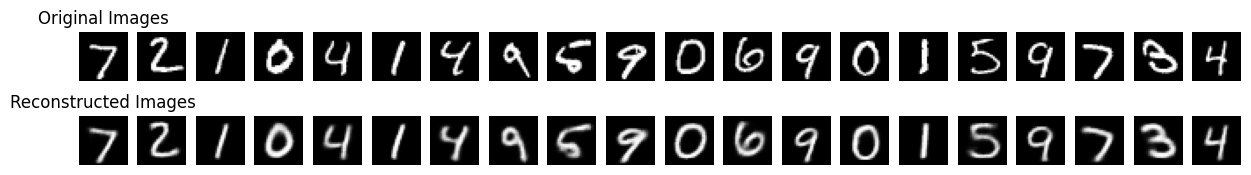

In [28]:
visualize_cvae(model, test_loader, device, 20)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [33]:
latent_dim = 10

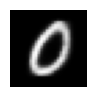

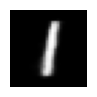

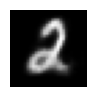

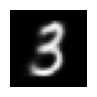

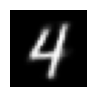

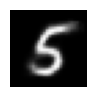

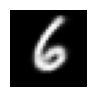

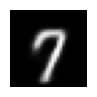

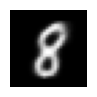

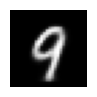

In [51]:
def sample_from_cvae(model, device, latent_vector, class_label):
    model.eval()
    with torch.no_grad():
        latent_vector = latent_vector.to(device)
        class_label = class_label.to(device)

        generated_image = model.decode(latent_vector, class_label)
        generated_image = generated_image.permute(0, 2, 3, 1).cpu().numpy()

        plt.figure(figsize=(1, 1))  # Установите желаемый размер окна
        plt.imshow(generated_image[0], cmap='gray')
        plt.axis('off')
        plt.show()

# Пример использования
latent_vector = torch.randn(1, latent_dim)  # Генерируем случайный латентный вектор

sample_from_cvae(model, device, latent_vector, torch.tensor([0]))  # Генерация изображения цифры 0
sample_from_cvae(model, device, latent_vector, torch.tensor([1]))  # Генерация изображения цифры 1
sample_from_cvae(model, device, latent_vector, torch.tensor([2]))  
sample_from_cvae(model, device, latent_vector, torch.tensor([3]))  
sample_from_cvae(model, device, latent_vector, torch.tensor([4]))  
sample_from_cvae(model, device, latent_vector, torch.tensor([5]))  
sample_from_cvae(model, device, latent_vector, torch.tensor([6]))
sample_from_cvae(model, device, latent_vector, torch.tensor([7]))
sample_from_cvae(model, device, latent_vector, torch.tensor([8]))
sample_from_cvae(model, device, latent_vector, torch.tensor([9]))



Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

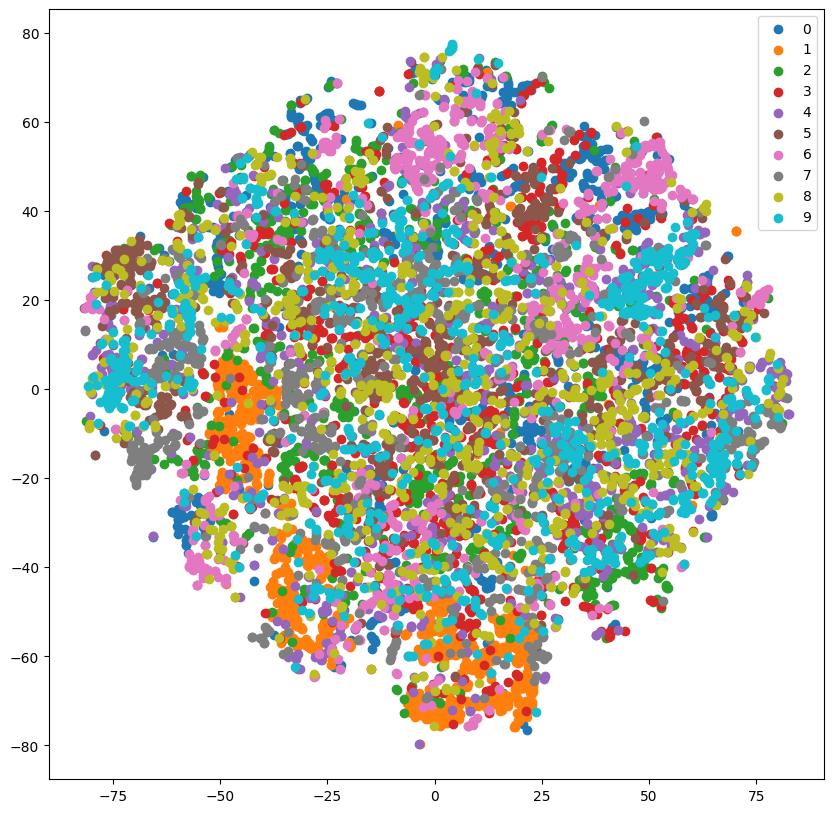

In [59]:
from sklearn.manifold import TSNE

def get_latent_representations(model, data_loader):
    latent = []
    labels = []
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            mu, logvar, _ = model(x, y)
            z = model.gaussian_sampler(mu, logvar)
            latent.append(z.cpu().numpy())
            labels.append(y.cpu().numpy())

    latent = np.concatenate(latent, axis=0)
    labels = np.concatenate(labels, axis=0)
    return latent, labels

# Получаем латентные представления для тестового датасета
test_latent, test_labels = get_latent_representations(model, test_loader)

# Сжимаем латентные представления до двумерной размерности
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
test_latent_2d = tsne.fit_transform(test_latent)

# Визуализируем точки в двумерном пространстве, покрасив их в разные цвета
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.scatter(test_latent_2d[test_labels == i, 0], test_latent_2d[test_labels == i, 1], label=str(i))
plt.legend()
plt.show()


Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

**Изменения значительные. Не наблюдается скопления образцов одинакового класса, вместо этого все они распределены по всему полю. Получается за счет именно такого распределения классов можно сэмплировать картинки любого из классов используя случайны вектор с более широким диапазоном mu и logsigma.**

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>